# GTHA housing market database
# OSEMN methodology Step 3: Explore
# Explore correlations between the features and target classes (3 classes)
# `top11f` feature set 

Top 11 features (missing past/future xy sales filled with mean future/past xy sales).

---

This notebook describes _Step 4: Model_ of OSEMN methodology performed on the Teranet dataset.

## Import dependencies

In [1]:
random_state = 1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import os
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, minmax_scale, MaxAbsScaler, StandardScaler, RobustScaler, Normalizer
from sklearn.preprocessing import QuantileTransformer, PowerTransformer, LabelEncoder
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.base import clone
# from pydotplus import graph_from_dot_data
from time import time

sns.set()

In [3]:
import sys

sys.path.append('../../src')

from io_utils import df_from_csv
from plot_utils import plot_hist, log_hist, stripplot_outliers
from model_utils import fit_model, targets_corr_3c

## Load Teranet data

In [4]:
data_path = '../../data/'
teranet_path = data_path + 'teranet/'
os.listdir(teranet_path)

['1.1_Teranet_DA.csv',
 '1.3_Teranet_DA_TAZ_PG_FSA.csv',
 '4_Teranet_lu_predict_3c.csv',
 '2_Teranet_consistent.csv',
 'parcel16_epoi13.csv',
 '1.2_Teranet_DA_TAZ.csv',
 '1.4_Teranet_DA_TAZ_FSA_LU_LUDMTI.csv',
 '1.4_Teranet_DA_TAZ_FSA_LU.csv',
 '4_Teranet_lu_predict_4c.csv',
 '.ipynb_checkpoints',
 'ParcelLandUse.zip',
 'ParcelLandUse',
 'HHSaleHistory.csv',
 '3_Teranet_nonan_new_cols.csv',
 'GTAjoinedLanduseSales']

In [5]:
teranet_df = df_from_csv(teranet_path + '4_Teranet_lu_predict_3c.csv', parse_dates=['registration_date'])

----- DataFrame loaded
in 121.52 seconds
with 5,188,513 rows
and 79 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction', 'municipality',
       'street_number', 'x', 'y', 'dauid', 'csduid', 'csdname', 'taz_o', 'fsa',
       'pca_id', 'postal_code_dmti', 'pin_lu', 'landuse', 'prop_code',
       'dmti_lu', 'street_name_raw', 'year', 'year_month', 'year3',
       'census_year', 'census2001_year', 'tts_year', 'tts1991_year', 'xy',
       'pin_total_sales', 'xy_total_sales', 'pin_prev_sales', 'xy_prev_sales',
       'xy_first_sale', 'pin_years_since_last_sale',
       'xy_years_since_last_sale', 'xy_years_to_next_sale',
       'da_days_since_last_sale', 'da_years_since_last_sale',
       'xy_sale_next_6m', 'price_2016', 'pin_price_cum_sum',
       'xy_price_cum_sum', 'pin_price_pct_change', 'xy_price_pct_change',
       'price_da_pct_chang

## Load Census data

In [6]:
census_path = data_path + 'census/'
os.listdir(census_path)

['da_census_income.csv',
 'Census data availability.xlsx',
 'da_census.xls',
 'da_census_select_tidy.csv',
 'da_census_income_shapefile',
 'da_census_select.csv']

In [7]:
census_df = df_from_csv(census_path + 'da_census_select_tidy.csv')

----- DataFrame loaded
in 0.16 seconds
with 36,728 rows
and 32 columns
-- Column names:
 Index(['DAUID', 'year', 'Avg_HHsize', 'Avg_HHinc', 'Avg_own_payt',
       'Avg_val_dwel', 'Avg_rent', 'Pop', 'PopDens', 'Dwel', 'DwelDens',
       'Sgl_det', 'Apt_5plus', 'Sgl_att', 'Owned', 'Rented', 'CarTrVan_d',
       'CarTrVan_p', 'PT', 'Walk', 'Bike', 'Lbrfrc', 'Emp', 'Unemp',
       'Not_lbrfrc', 'Employee', 'Self_emp', 'At_home', 'No_fix_wkpl',
       'Usl_wkpl', 'Blue_cljob', 'White_cljob'],
      dtype='object')


## Load TTS data

In [8]:
tts_path = data_path + 'tts/'
os.listdir(tts_path)

['tts_num_jobs_tidy.csv',
 'TAZ_2001shp.zip',
 'TAZ_2001shp',
 'taz_tts_tidy.csv',
 'taz_info.csv',
 'TTS_variables.xlsx',
 'taz_tts.xlsx',
 'Num_of_Jobs.xlsx']

In [9]:
tts_df = df_from_csv(tts_path + 'taz_tts_tidy.csv')

----- DataFrame loaded
in 0.01 seconds
with 12,012 rows
and 8 columns
-- Column names:
 Index(['TAZ_O', 'year', 'Pop', 'FT_wrk', 'Stu', 'HH', 'Jobs', 'Cars'], dtype='object')


## Join Census data to Teranet data

In [10]:
t = time()
df = pd.merge(teranet_df, census_df, how='left',
              left_on=['dauid', 'census2001_year'], right_on=['DAUID', 'year'])
df = df.drop(['DAUID', 'year_y'], axis=1).rename(columns={'year_x': 'year'})
elapsed = time() - t
print("----- Census variables were joined to the DataFrame"
      "\nin {0:,.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

----- Census variables were joined to the DataFrame
in 58.59 seconds (0.98 minutes)
with 5,188,513 rows
and 109 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction',
       ...
       'Emp', 'Unemp', 'Not_lbrfrc', 'Employee', 'Self_emp', 'At_home',
       'No_fix_wkpl', 'Usl_wkpl', 'Blue_cljob', 'White_cljob'],
      dtype='object', length=109)


## Join TTS data to Teranet data

In [11]:
t = time()
df = pd.merge(df, tts_df, how='left',
              left_on=['taz_o', 'tts_year'], right_on=['TAZ_O', 'year'])
df = df.drop(['taz_o', 'year_y'], axis=1).rename(columns={'year_x': 'year'})
elapsed = time() - t
print("----- TTS variables were joined to the DataFrame"
      "\nin {0:,.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

----- TTS variables were joined to the DataFrame
in 62.45 seconds (1.04 minutes)
with 5,188,513 rows
and 115 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction',
       ...
       'Usl_wkpl', 'Blue_cljob', 'White_cljob', 'TAZ_O', 'Pop_y', 'FT_wrk',
       'Stu', 'HH', 'Jobs', 'Cars'],
      dtype='object', length=115)


## Take a train-test subset of Teranet records

In [12]:
year_train_test = 2012
year_val1 = 2011
year_val2 = 2013

s = df.query('year == @year_train_test')
s_val1 = df.query('year == @year_val1')
s_val2 = df.query('year == @year_val2')

print("{0:,} Teranet records in the train-test subset (records from {1}).".format(len(s), year_train_test))
print("{0:,} Teranet records in the validation subset #1 (records from {1}).".format(len(s_val1), year_val1))
print("{0:,} Teranet records in the validation subset #2 (records from {1}).".format(len(s_val2), year_val2))

205,341 Teranet records in the train-test subset (records from 2012).
219,130 Teranet records in the validation subset #1 (records from 2011).
207,686 Teranet records in the validation subset #2 (records from 2013).


## Select features and fill missing values

In [13]:
s.columns

Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction',
       ...
       'Usl_wkpl', 'Blue_cljob', 'White_cljob', 'TAZ_O', 'Pop_y', 'FT_wrk',
       'Stu', 'HH', 'Jobs', 'Cars'],
      dtype='object', length=115)

In [14]:
top11f = ['xy_total_sales', 'xy_prev_sales', 'xy_first_sale',
          'xy_years_since_last_sale', 'xy_years_to_next_sale', 'med_price_xy',
          'Avg_HHsize', 'Avg_rent', 'PopDens', 'DwelDens', 'Apt_5plus',
          'lucr_house', 'lucr', 'lucr_condo', 'lucr_other']
s = s[top11f]
s_val1 = s_val1[top11f]
s_val2 = s_val2[top11f]
s.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205341 entries, 0 to 205340
Data columns (total 15 columns):
xy_total_sales              205341 non-null int64
xy_prev_sales               205341 non-null int64
xy_first_sale               205341 non-null bool
xy_years_since_last_sale    176503 non-null float64
xy_years_to_next_sale       137302 non-null float64
med_price_xy                205341 non-null float64
Avg_HHsize                  204722 non-null float64
Avg_rent                    204736 non-null float64
PopDens                     205341 non-null float64
DwelDens                    205341 non-null float64
Apt_5plus                   204722 non-null float64
lucr_house                  205341 non-null bool
lucr                        205341 non-null object
lucr_condo                  205341 non-null bool
lucr_other                  205341 non-null bool
dtypes: bool(4), float64(8), int64(2), object(1)
memory usage: 19.6+ MB


In [15]:
col1 = 'xy_years_to_next_sale'
col2 = 'xy_years_since_last_sale'
mask1 = s[col1].isnull()
print("For records with missing '{0}', values of '{1}' are: mean={2:,.2f}, median={3:,.2f}"
      .format(col1, col2, s.loc[mask1, col2].mean(), s.loc[mask1, col2].median()))
mask1 = s[col2].isnull()
print("For records with missing '{0}', values of '{1}' are: mean={2:,.2f}, median={3:,.2f}"
      .format(col2, col1, s.loc[mask1, col1].mean(), s.loc[mask1, col1].median()))

For records with missing 'xy_years_to_next_sale', values of 'xy_years_since_last_sale' are: mean=7.59, median=5.89
For records with missing 'xy_years_since_last_sale', values of 'xy_years_to_next_sale' are: mean=2.07, median=1.72


In [16]:
# missing year to next sale is replaced with median year since last sale and vice versa
mask1 = s[col1].isnull()
s.loc[mask1, col1] = s.loc[mask1, col2].median()
mask1 = s_val1[col1].isnull()
s_val1.loc[mask1, col1] = s_val1.loc[mask1, col2].median()
mask1 = s_val2[col1].isnull()
s_val2.loc[mask1, col1] = s_val2.loc[mask1, col2].median()

mask1 = s[col2].isnull()
s.loc[mask1, col2] = s.loc[mask1, col1].median()
mask1 = s_val1[col2].isnull()
s_val1.loc[mask1, col2] = s_val1.loc[mask1, col1].median()
mask1 = s_val2[col2].isnull()
s_val2.loc[mask1, col2] = s_val2.loc[mask1, col1].median()

s.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205341 entries, 0 to 205340
Data columns (total 15 columns):
xy_total_sales              205341 non-null int64
xy_prev_sales               205341 non-null int64
xy_first_sale               205341 non-null bool
xy_years_since_last_sale    205341 non-null float64
xy_years_to_next_sale       205341 non-null float64
med_price_xy                205341 non-null float64
Avg_HHsize                  204722 non-null float64
Avg_rent                    204736 non-null float64
PopDens                     205341 non-null float64
DwelDens                    205341 non-null float64
Apt_5plus                   204722 non-null float64
lucr_house                  205341 non-null bool
lucr                        205341 non-null object
lucr_condo                  205341 non-null bool
lucr_other                  205341 non-null bool
dtypes: bool(4), float64(8), int64(2), object(1)
memory usage: 19.6+ MB


In [17]:
s = s.dropna()
s_val1 = s_val1.dropna()
s_val2 = s_val2.dropna()
print("{0:,} rows in train-test subset, {1:,} rows in validation subset #1, {2:,} rows in validation subset #2"
      .format(len(s), len(s_val1), len(s_val2)))

204,722 rows in train-test subset, 217,955 rows in validation subset #1, 207,281 rows in validation subset #2


In [18]:
target_cols = 4
feat_cols = s.columns[:-target_cols]
feat_cols

Index(['xy_total_sales', 'xy_prev_sales', 'xy_first_sale',
       'xy_years_since_last_sale', 'xy_years_to_next_sale', 'med_price_xy',
       'Avg_HHsize', 'Avg_rent', 'PopDens', 'DwelDens', 'Apt_5plus'],
      dtype='object')

In [23]:
feat_set_name = 'top11f_3c'

## Pearson correlation coefficients with the target classes

In [20]:
s.columns

Index(['xy_total_sales', 'xy_prev_sales', 'xy_first_sale',
       'xy_years_since_last_sale', 'xy_years_to_next_sale', 'med_price_xy',
       'Avg_HHsize', 'Avg_rent', 'PopDens', 'DwelDens', 'Apt_5plus',
       'lucr_house', 'lucr', 'lucr_condo', 'lucr_other'],
      dtype='object')

----- Pearson correlation coefficient between features and target classes

         strongest negative correlation (top 10):
                          var    variable     value
4      xy_years_to_next_sale  lucr_condo -0.528633
18                  Avg_rent  lucr_house -0.431383
11            xy_total_sales  lucr_house -0.408933
3   xy_years_since_last_sale  lucr_condo -0.405152
21                 Apt_5plus  lucr_house -0.399667
12             xy_prev_sales  lucr_house -0.375960
6                 Avg_HHsize  lucr_condo -0.335238
20                  DwelDens  lucr_house -0.259724
2              xy_first_sale  lucr_condo -0.244578
25  xy_years_since_last_sale  lucr_other -0.225866 

         strongest positive correlation (top 10):
                          var    variable     value
15     xy_years_to_next_sale  lucr_house  0.702362
14  xy_years_since_last_sale  lucr_house  0.604159
17                Avg_HHsize  lucr_house  0.395717
10                 Apt_5plus  lucr_condo  0.381494
1    

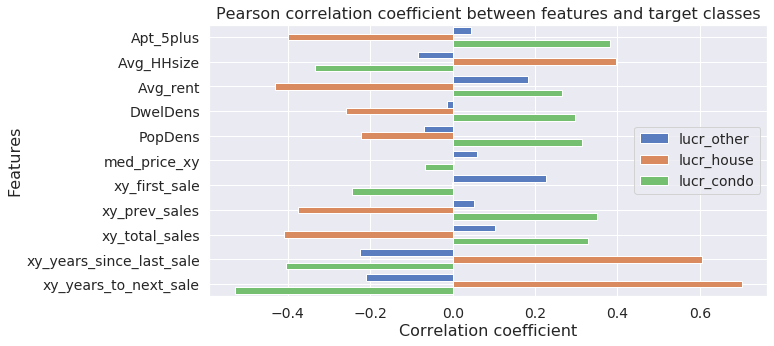

In [57]:
target_list = ['lucr_condo', 'lucr_house', 'lucr_other']
target_var = 'lucr'
save_path = 'results/plots/features/{0}/{1}_lucr_corr.png'.format(feat_set_name, feat_set_name)
targets_corr(s, target_list, target_var, fig_height=5, output='save', save_path=save_path)

In [ ]:
print("Pairplot of {0} features would produce {1:.0f} subplots.".format(len(feat_cols), len(feat_cols) ** 2))

Plotting took 1,481.38 seconds (24.69 minutes).


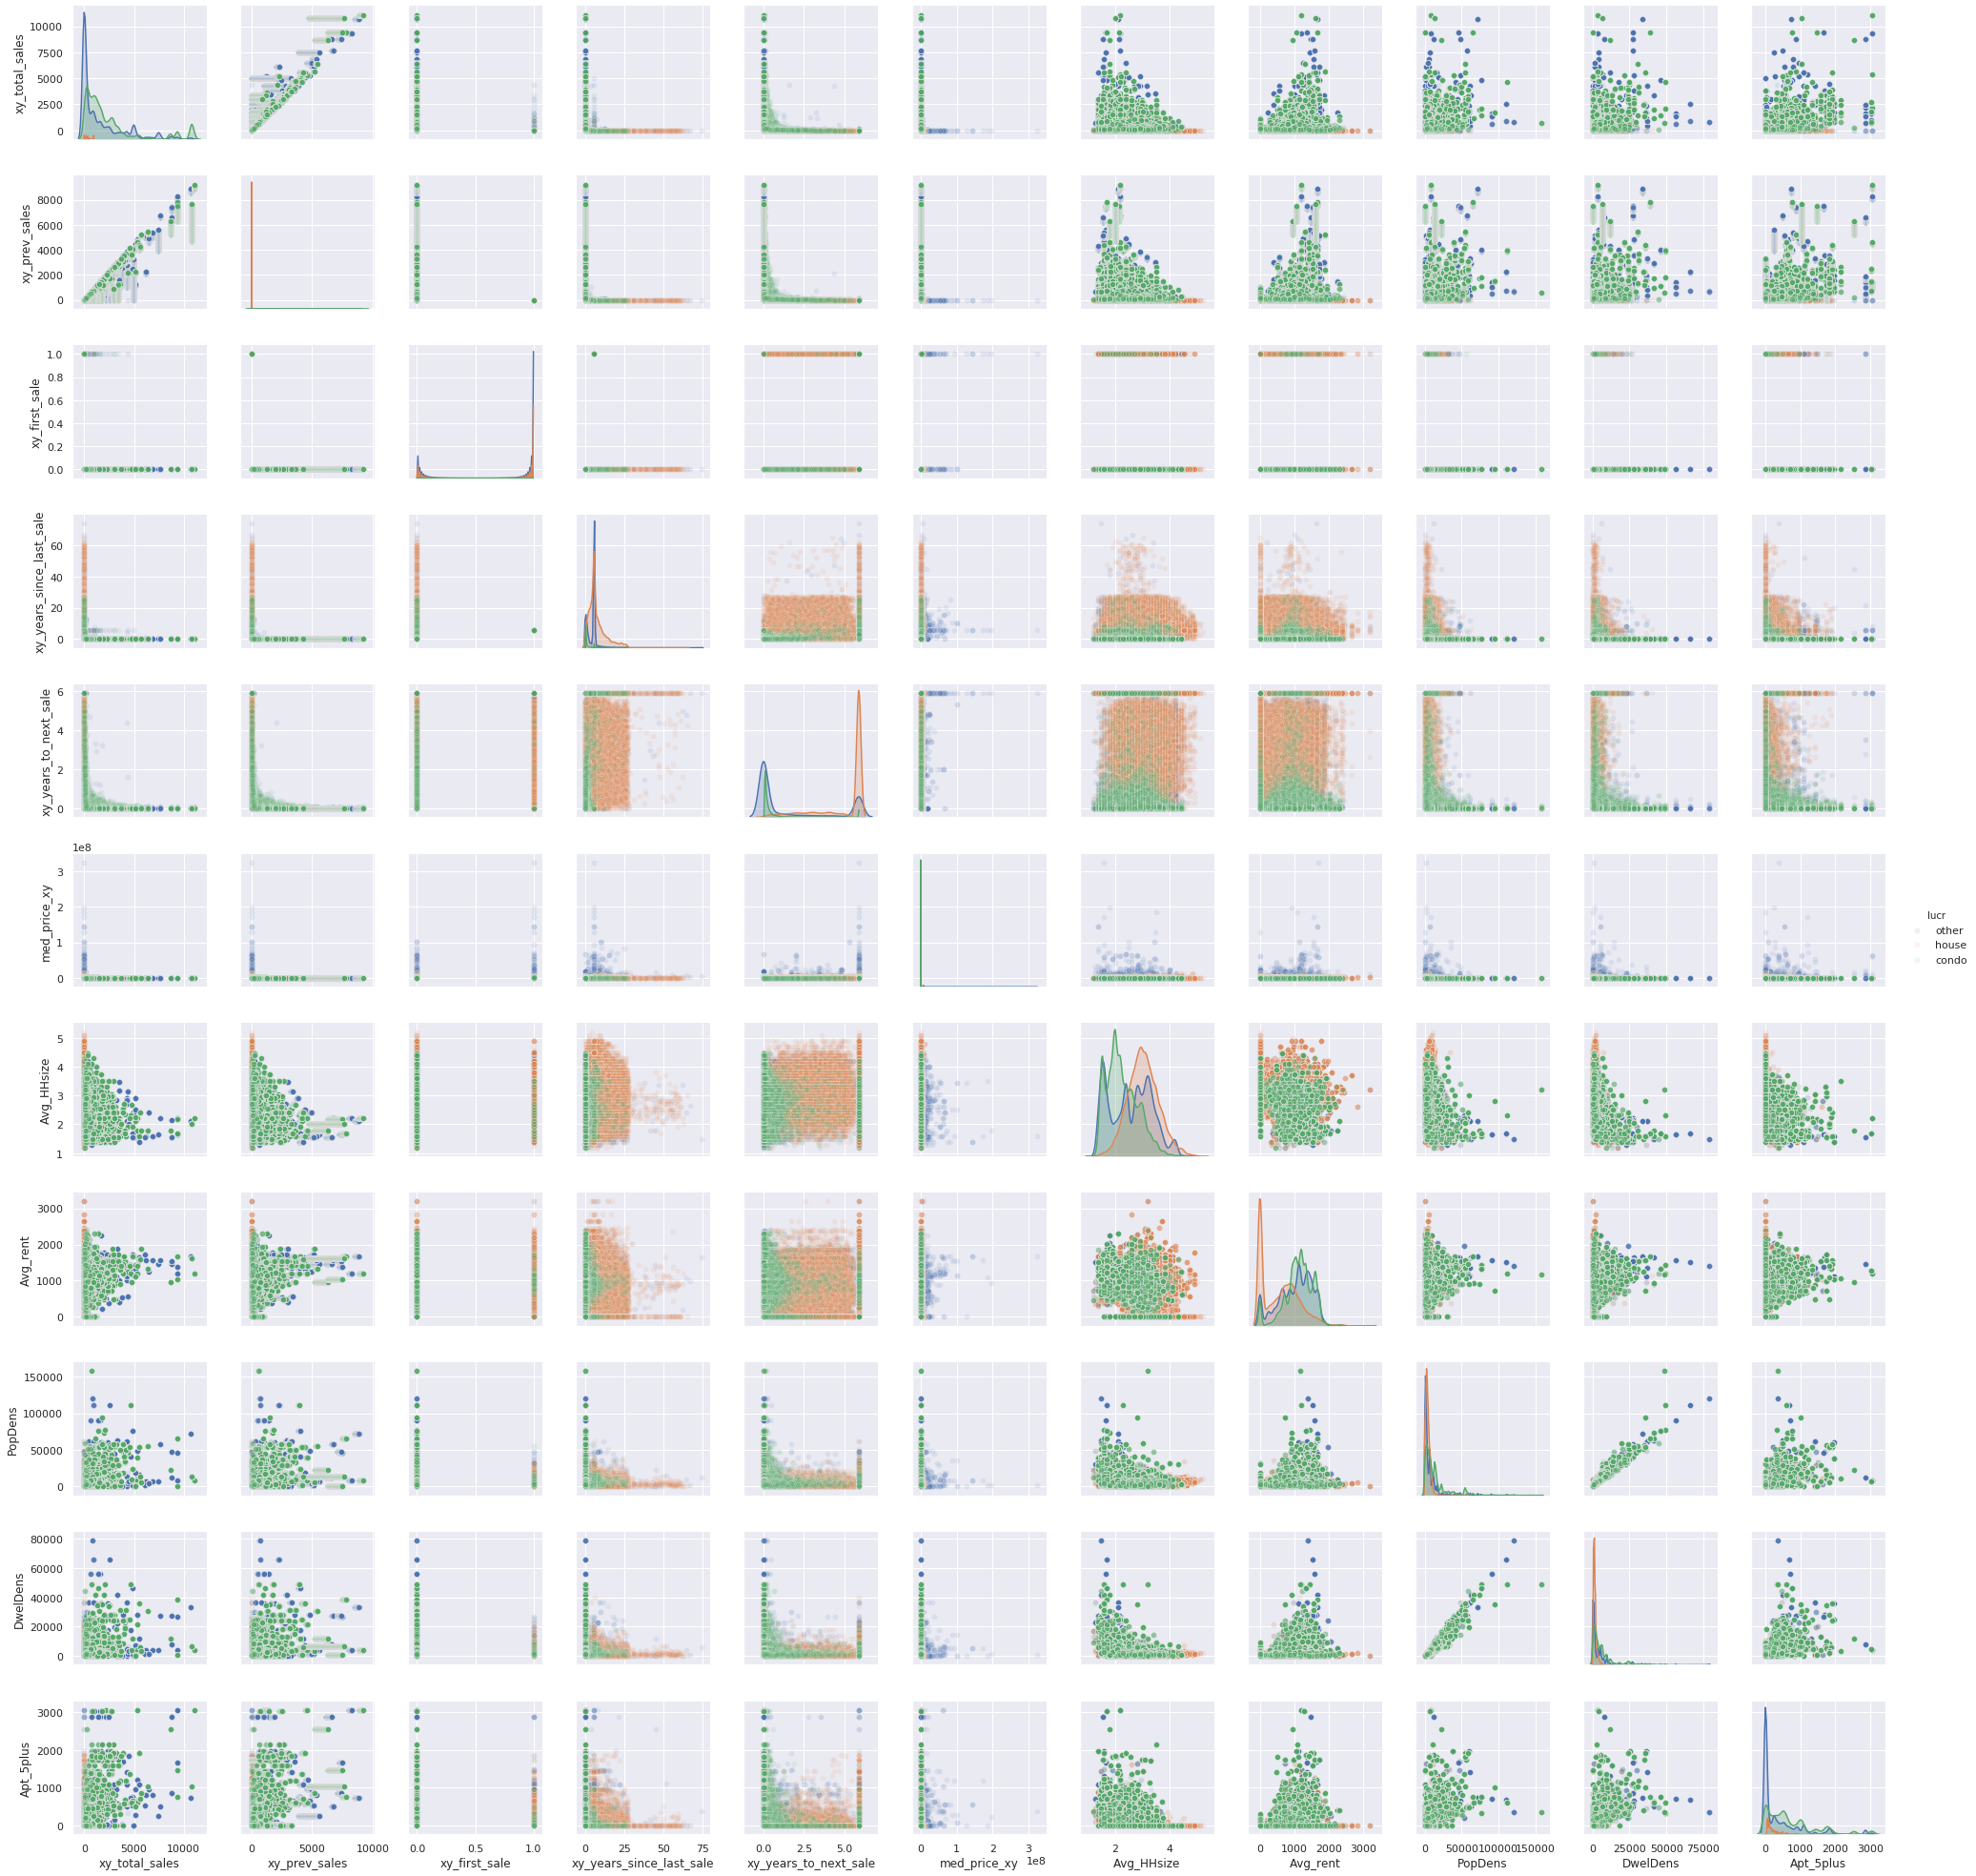

In [27]:
t = time()
pg = sns.pairplot(s[feat_cols.append(pd.Index(['lucr']))], hue='lucr', kind='scatter', plot_kws={'alpha': 0.1})
pg.savefig('results/plots/features/{0}/{1}_pairplot.png'.format(feat_set_name, feat_set_name), dpi=400)
elapsed = time() - t
print("Plotting took {0:,.2f} seconds ({1:,.2f} minutes).".format(elapsed, elapsed / 60))

## Feature exploration

### Stripplots by class

In [25]:
target_col = 'lucr'

#### Temporal

##### xy_total_sales

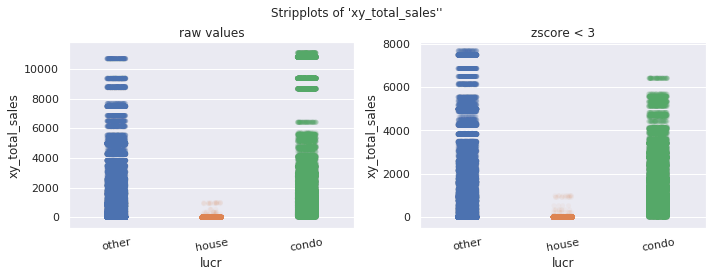

In [29]:
feat = 'xy_total_sales'
outlier_zscore = 3
save_path = 'results/plots/features/{0}/stripplots/{1}.png'.format(feat_set_name, feat)
stripplot_outliers(s, feat, target_col, outlier_zscore, output='save', save_path=save_path)

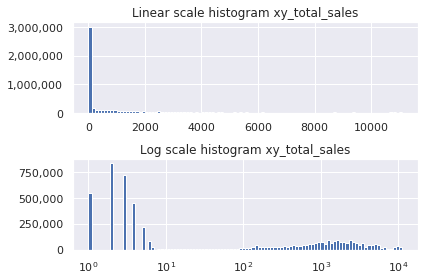

In [30]:
mask1 = df[feat] != 0 # to plot the log scale
mask2 = df[feat].isnull()
log_hist(df.loc[mask1 & ~mask2, feat], title=feat, bins=100)

##### xy_prev_sales

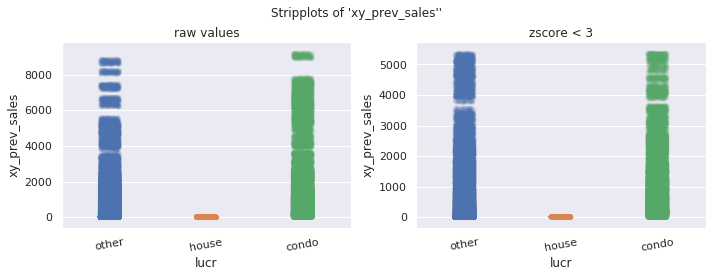

In [31]:
feat = 'xy_prev_sales'
outlier_zscore = 3
save_path = 'results/plots/features/{0}/stripplots/{1}.png'.format(feat_set_name, feat)
stripplot_outliers(s, feat, target_col, outlier_zscore, output='save', save_path=save_path)

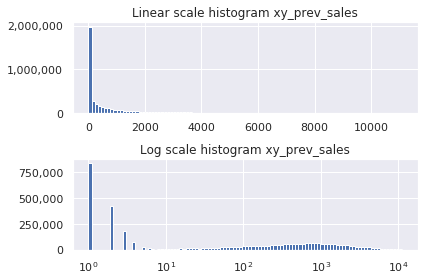

In [32]:
mask1 = df[feat] != 0 # to plot the log scale
mask2 = df[feat].isnull()
log_hist(df.loc[mask1 & ~mask2, feat], title=feat, bins=100)

##### xy_first_sale

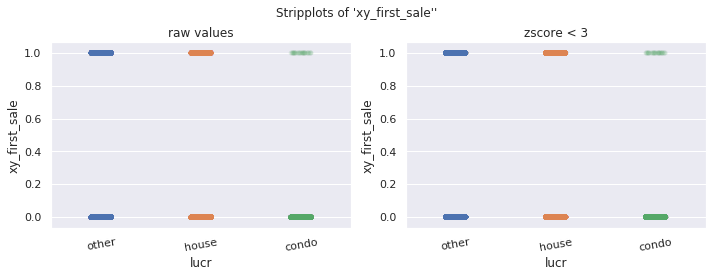

In [33]:
feat = 'xy_first_sale'
outlier_zscore = 3
save_path = 'results/plots/features/{0}/stripplots/{1}.png'.format(feat_set_name, feat)
stripplot_outliers(s, feat, target_col, outlier_zscore, output='save', save_path=save_path)

##### xy_years_since_last_sale

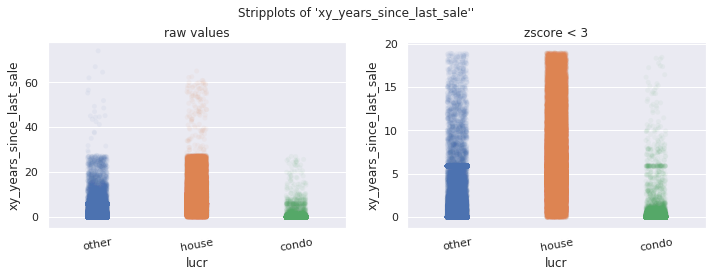

In [34]:
feat = 'xy_years_since_last_sale'
outlier_zscore = 3
save_path = 'results/plots/features/{0}/stripplots/{1}.png'.format(feat_set_name, feat)
stripplot_outliers(s, feat, target_col, outlier_zscore, output='save', save_path=save_path)

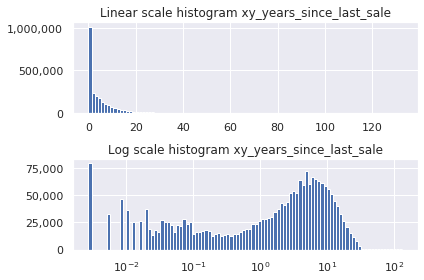

In [35]:
mask1 = df[feat] != 0 # to plot the log scale
mask2 = df[feat].isnull()
log_hist(df.loc[mask1 & ~mask2, feat], title=feat, bins=100)

##### xy_years_to_next_sale

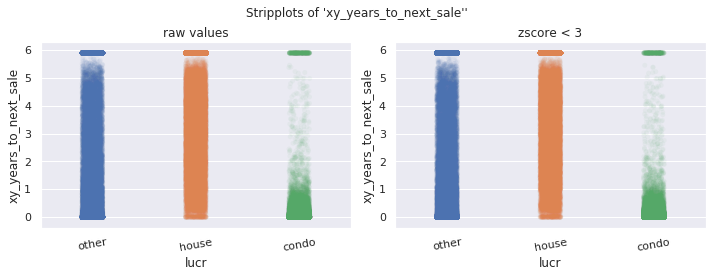

In [36]:
feat = 'xy_years_to_next_sale'
outlier_zscore = 3
save_path = 'results/plots/features/{0}/stripplots/{1}.png'.format(feat_set_name, feat)
stripplot_outliers(s, feat, target_col, outlier_zscore, output='save', save_path=save_path)

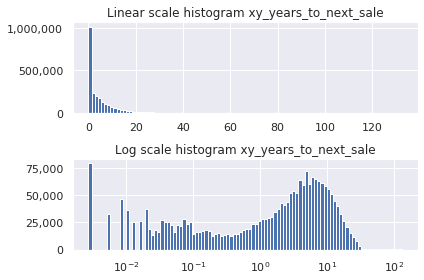

In [37]:
mask1 = df[feat] != 0 # to plot the log scale
mask2 = df[feat].isnull()
log_hist(df.loc[mask1 & ~mask2, feat], title=feat, bins=100)

#### Monetary

##### med_price_xy

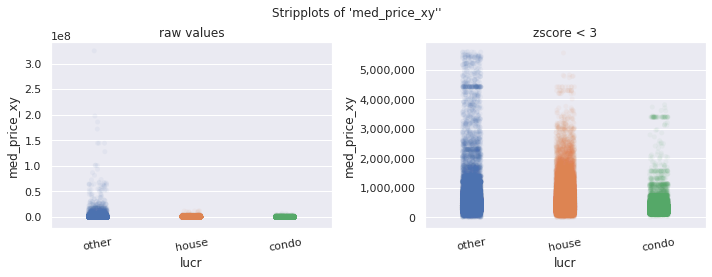

In [38]:
feat = 'med_price_xy'
outlier_zscore = 3
save_path = 'results/plots/features/{0}/stripplots/{1}.png'.format(feat_set_name, feat)
stripplot_outliers(s, feat, target_col, outlier_zscore, output='save', save_path=save_path, p2_ysep=True)

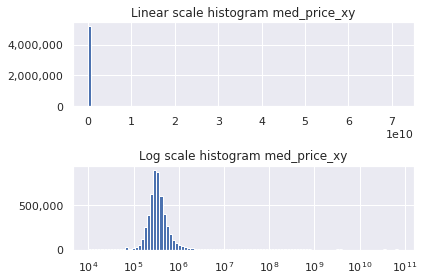

In [39]:
mask1 = df[feat] != 0 # to plot the log scale
mask2 = df[feat].isnull()
log_hist(df.loc[mask1 & ~mask2, feat], title=feat, bins=100)

#### Census

##### Avg_HHsize

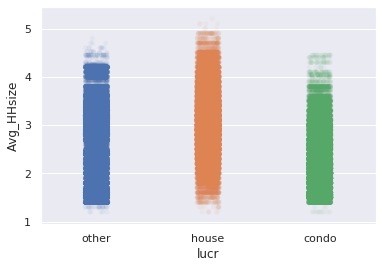

In [40]:
feat = 'Avg_HHsize'
sns.stripplot(data=s, y=feat, x='lucr', alpha=0.05)
plt.savefig('results/plots/features/{0}/stripplots/{1}.png'.format(feat_set_name, feat), dpi=300)

##### Avg_rent

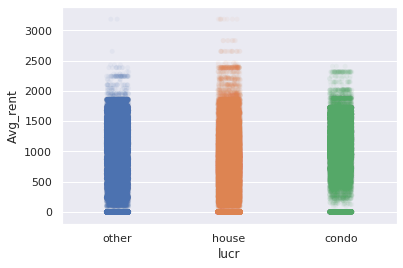

In [41]:
feat = 'Avg_rent'
sns.stripplot(data=s, y=feat, x='lucr', alpha=0.05)
plt.savefig('results/plots/features/{0}/stripplots/{1}.png'.format(feat_set_name, feat), dpi=300)

##### PopDens

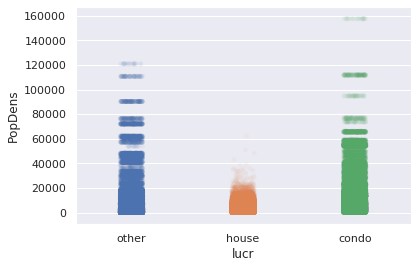

In [42]:
feat = 'PopDens'
sns.stripplot(data=s, y=feat, x='lucr', alpha=0.05)
plt.savefig('results/plots/features/{0}/stripplots/{1}.png'.format(feat_set_name, feat), dpi=300)

##### DwelDens

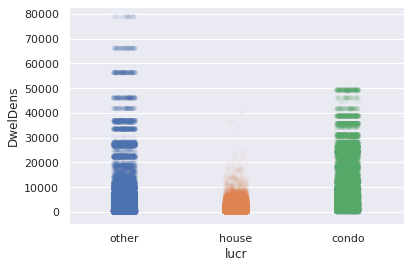

In [43]:
feat = 'DwelDens'
sns.stripplot(data=s, y=feat, x='lucr', alpha=0.05)
plt.savefig('results/plots/features/{0}/stripplots/{1}.png'.format(feat_set_name, feat), dpi=300)

##### Apt_5plus

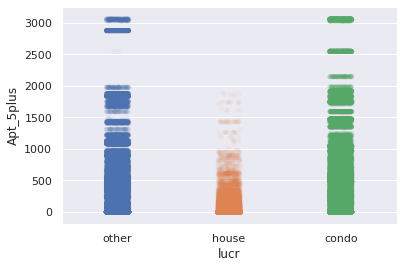

In [44]:
feat = 'Apt_5plus'
sns.stripplot(data=s, y=feat, x='lucr', alpha=0.05)
plt.savefig('results/plots/features/{0}/stripplots/{1}.png'.format(feat_set_name, feat), dpi=300)

## Effects of different scalers on data with outliers

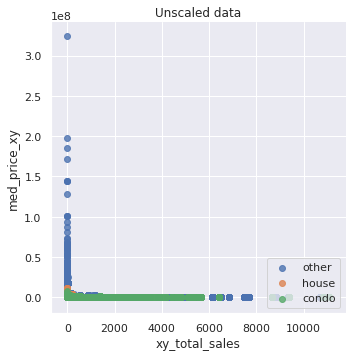

In [68]:
col1 = 'xy_total_sales'
col2 = 'med_price_xy'
name = 'Unscaled data'
sns.lmplot(data=s, x=col1, y=col2, fit_reg=False, hue='lucr', legend=False)
plt.title(name)
plt.legend(loc='lower right');

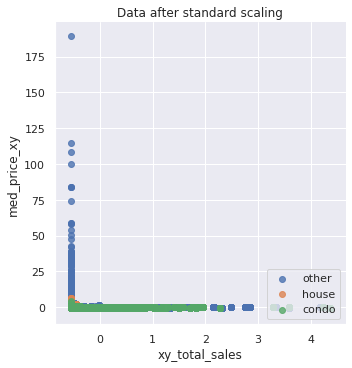

In [59]:
name = 'Data after standard scaling'
s_tr = s.copy()
s_tr[[col1, col2]] = StandardScaler().fit_transform(s[[col1, col2]].values)
sns.lmplot(data=s_tr, x=col1, y=col2, fit_reg=False, hue='lucr', legend=False)
plt.title(name)
plt.legend(loc='lower right');

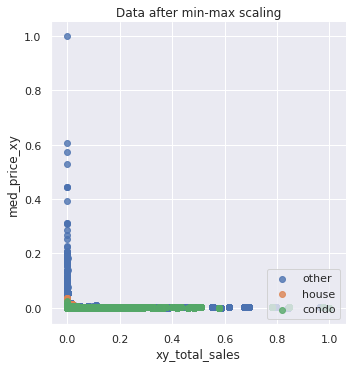

In [60]:
name = 'Data after min-max scaling'
s_tr = s.copy()
s_tr[[col1, col2]] = MinMaxScaler().fit_transform(s[[col1, col2]].values)
sns.lmplot(data=s_tr, x=col1, y=col2, fit_reg=False, hue='lucr', legend=False)
plt.title(name)
plt.legend(loc='lower right');

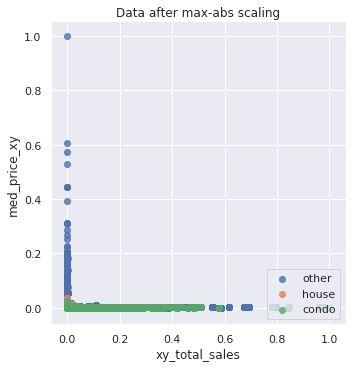

In [61]:
name = 'Data after max-abs scaling'
s_tr = s.copy()
s_tr[[col1, col2]] = MaxAbsScaler().fit_transform(s[[col1, col2]].values)
sns.lmplot(data=s_tr, x=col1, y=col2, fit_reg=False, hue='lucr', legend=False)
plt.title(name)
plt.legend(loc='lower right');

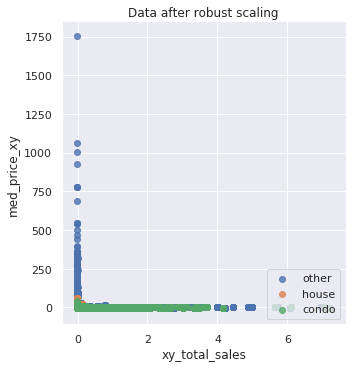

In [62]:
name = 'Data after robust scaling'
s_tr = s.copy()
s_tr[[col1, col2]] = RobustScaler(quantile_range=(25, 75)).fit_transform(s[[col1, col2]].values)
sns.lmplot(data=s_tr, x=col1, y=col2, fit_reg=False, hue='lucr', legend=False)
plt.title(name)
plt.legend(loc='lower right');

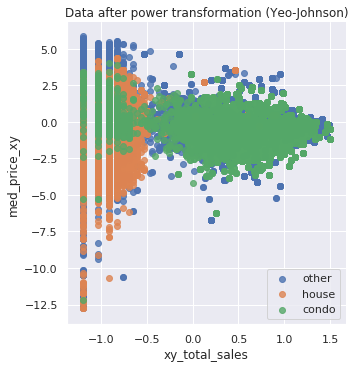

In [63]:
name = 'Data after power transformation (Yeo-Johnson)'
s_tr = s.copy()
s_tr[[col1, col2]] = PowerTransformer(method='yeo-johnson').fit_transform(s[[col1, col2]].values)
sns.lmplot(data=s_tr, x=col1, y=col2, fit_reg=False, hue='lucr', legend=False)
plt.title(name)
plt.legend(loc='lower right');

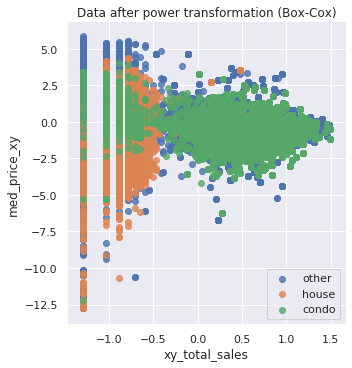

In [64]:
name = 'Data after power transformation (Box-Cox)'
s_tr = s.copy()
s_tr[[col1, col2]] = PowerTransformer(method='box-cox').fit_transform(s[[col1, col2]].values)
sns.lmplot(data=s_tr, x=col1, y=col2, fit_reg=False, hue='lucr', legend=False)
plt.title(name)
plt.legend(loc='lower right');

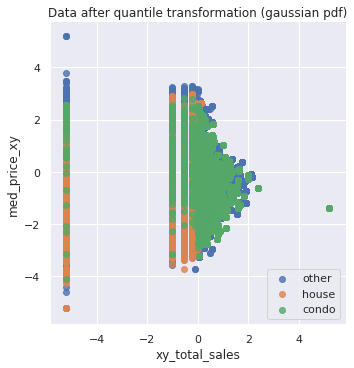

In [65]:
name = 'Data after quantile transformation (gaussian pdf)'
s_tr = s.copy()
s_tr[[col1, col2]] = QuantileTransformer(output_distribution='normal').fit_transform(s[[col1, col2]].values)
sns.lmplot(data=s_tr, x=col1, y=col2, fit_reg=False, hue='lucr', legend=False)
plt.title(name)
plt.legend(loc='lower right');

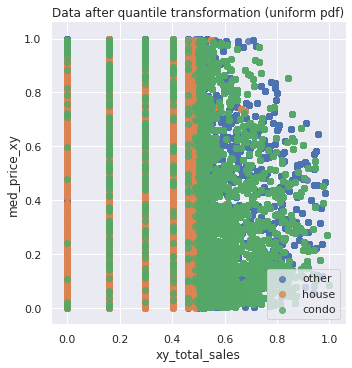

In [66]:
name = 'Data after quantile transformation (uniform pdf)'
s_tr = s.copy()
s_tr[[col1, col2]] = QuantileTransformer(output_distribution='uniform').fit_transform(s[[col1, col2]].values)
sns.lmplot(data=s_tr, x=col1, y=col2, fit_reg=False, hue='lucr', legend=False)
plt.title(name)
plt.legend(loc='lower right');

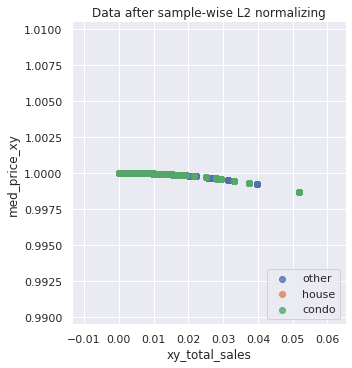

In [67]:
name = 'Data after sample-wise L2 normalizing'
s_tr = s.copy()
s_tr[[col1, col2]] = Normalizer().fit_transform(s[[col1, col2]].values)
sns.lmplot(data=s_tr, x=col1, y=col2, fit_reg=False, hue='lucr', legend=False)
plt.title(name)
plt.legend(loc='lower right');